# Reverse Image Search 

##### Reverse image search enables developers and researchers to build scenarios beyond simple keyword search. From discovering visually similar objects on Pinterest to recommending similar songs on Spotify to camera-based product search on Amazon, a similar class of technology under the hood is used.

In [2]:
# Import all important modules

import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [3]:
# extract bottlenech features

model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [4]:
features = extract_features("./IMG20211024125948_01.jpg", model)

In [5]:
print(len(features))

100352


In [6]:
features = extract_features("./putin_meet_ind_stud.jpg", model)

In [7]:
print(len(features))

100352


In [8]:
# Recursively looks for all the image files defined by their extension under a directory

extensions = ['.jpg', '.JPG', ',jpeg', '.JPEG','.png','.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
        
    return file_list

In [15]:
# provide path to our function get_file_list

root_dir = "./objDet"
filenames = sorted(get_file_list(root_dir))

In [17]:
# go through all filenames in the dataset, extract their features, and append them to feature_list

feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

C:\Users\colak\miniconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [19]:
# write these features to a pickle file so that we can use them in the future without having to recalculate them

pickle.dump(feature_list, open("./data/features-caltech101-resnet.pickle", 'wb'))
pickle.dump(filenames, open("./data/filenames-caltech101.pickle", 'wb'))

### Similarity Search

###### Given a post image, our aim is to find another post in our fact-checked news collection dataset similar to the current one

In [12]:
# loading the precomputed features:

filenames = pickle.load(open("data/filenames-caltech101.pickle", 'rb'))
feature_list = pickle.load(open("data/features-caltech101-resnet.pickle", 'rb'))

In [15]:
# Using python's machine learning library scikit-learn for finding nearest neighbours of the query features

from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm="brute", metric="euclidean").fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])

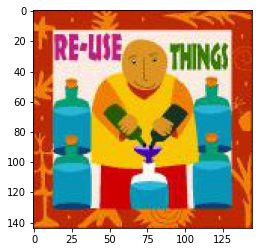

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#show the plots as a cell within the Jupyter Notebooks
%matplotlib inline   
plt.imshow(mpimg.imread(filenames[0]))

In [46]:
# let's examine the nearest neighbors by plotting the first result
# out_images = np.array(X_train)[indices.astype(int)]
index = indices[0]
for index in indices:
    print(index)

[   0    8  168 3725 2983]


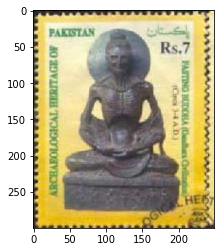

In [50]:
plt.imshow(mpimg.imread(filenames[2983]))

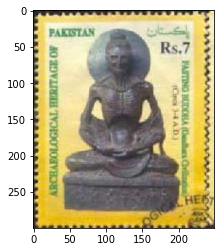

In [54]:
plt.imshow(mpimg.imread(filenames[indices[0][4]]))

In [56]:
for i in range(5):
    print(distances[0][i])

8.4293696e-08
1.1177828
1.1700674
1.1708246
1.1817672


In [71]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]


# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]


# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        #plt.savefig('results/' + str(random.randint(0,10000))+'.pdf', format='pdf', dpi=1000)
        # We will use this line repeatedly in our code.

C:\Users\colak\miniconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
C:\Users\colak\miniconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
C:\Users\colak\miniconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
C:\Users\colak\miniconda3\lib\site-packages\ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
C:\Users\colak\miniconda3\lib\site-packages\ipykernel_launcher.py:19: Matplo

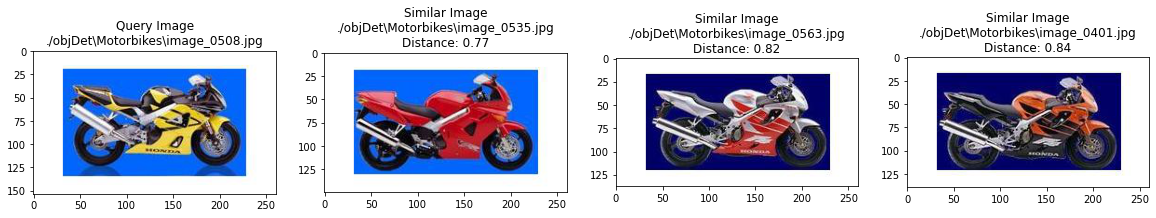

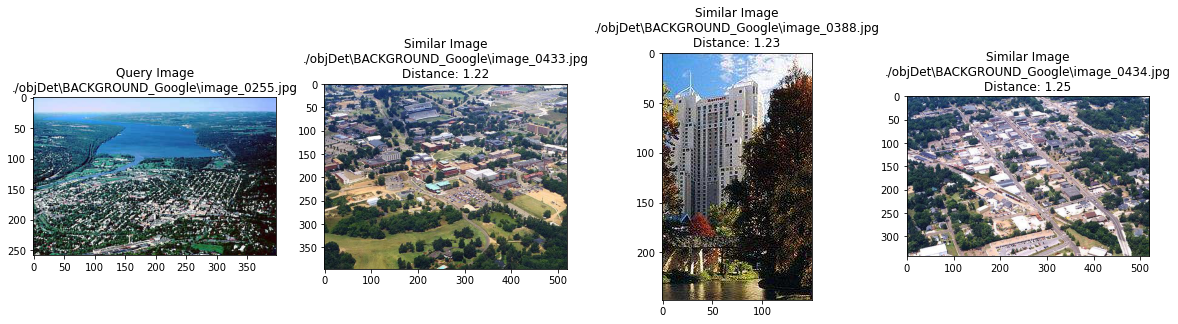

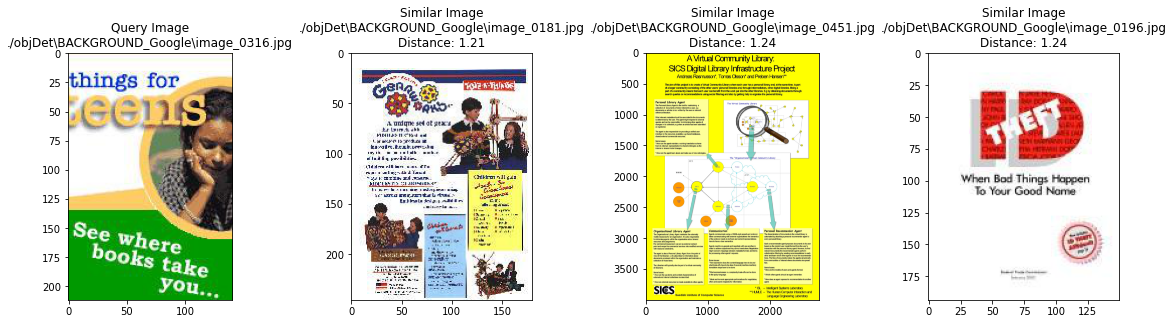

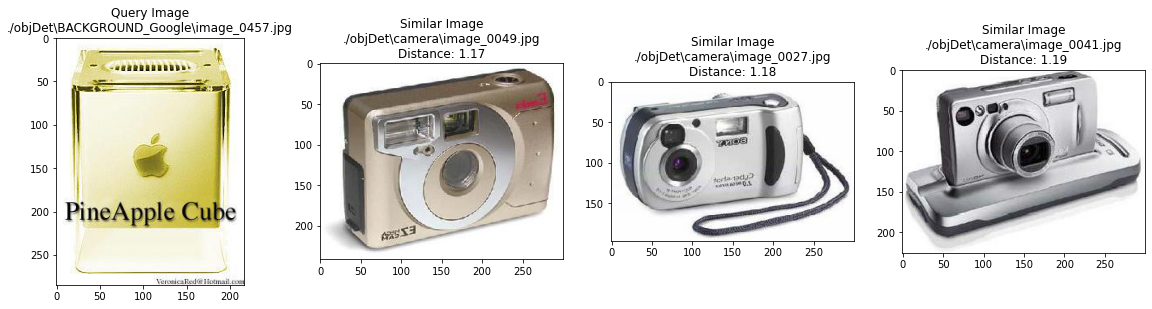

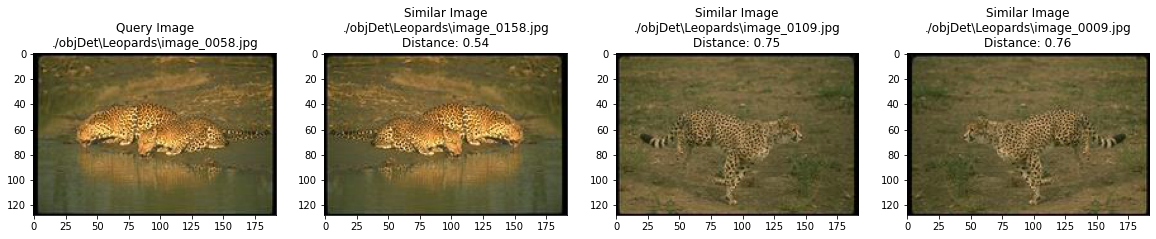

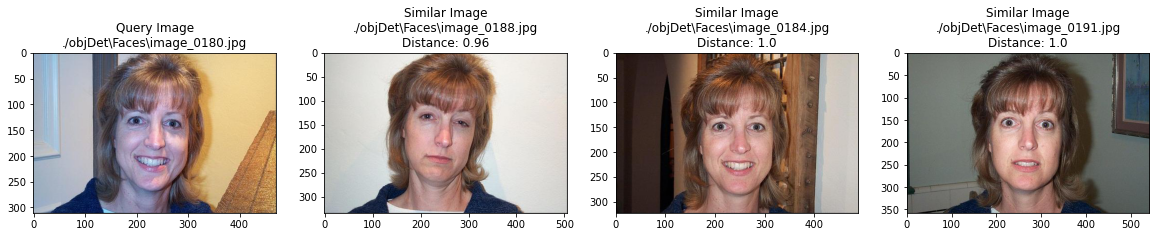

In [73]:
for i in range(6):
    random_image_index = random.randint(0, 2000)
    distances, indices = neighbors.kneighbors(
        [feature_list[random_image_index]])
    # Don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + \
        [filenames[indices[0][i]] for i in range(1, 4)]
    plot_images(similar_image_paths, distances[0])